
# Imports

In [1]:
########################## EDA
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from wordcloud import WordCloud

########################## Preprecessing
import spacy
from time import time
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

########################## Machine Learning
from sklearn.preprocessing     import StandardScaler
from sklearn.linear_model      import LogisticRegression
from sklearn.naive_bayes       import MultinomialNB
from sklearn.naive_bayes       import BernoulliNB
from sklearn.ensemble          import RandomForestClassifier
from xgboost                   import XGBClassifier

########################## Machine Learning Evaluation
from sklearn.metrics         import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


pd.set_option('max_colwidth', None)

# Read data

In [2]:
df = pd.read_csv("imdb.csv")

df_train = df.sample(frac = 0.8)
  
df_valid = df.drop(df_train.index)

print("Number of documents in training data: %d" % len(df_train))
print("Number of documents in validation data: %d" % len(df_valid))

Number of documents in training data: 20000
Number of documents in validation data: 5000


In [3]:
df.groupby('sentiment').count()

,review
sentiment,
0,12500
1,12500


# EDA
### Target

C:\Users\Igor\anaconda3\envs\Strive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

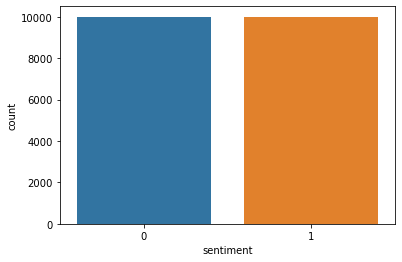

In [4]:
sb.countplot(df_train['sentiment'])

### Text

In [5]:
positive = df[df['sentiment']==0]['review']
negative = df[df['sentiment']==1]['review']

Wall time: 15.8 s


Text(0.5, 1.0, 'Negative')

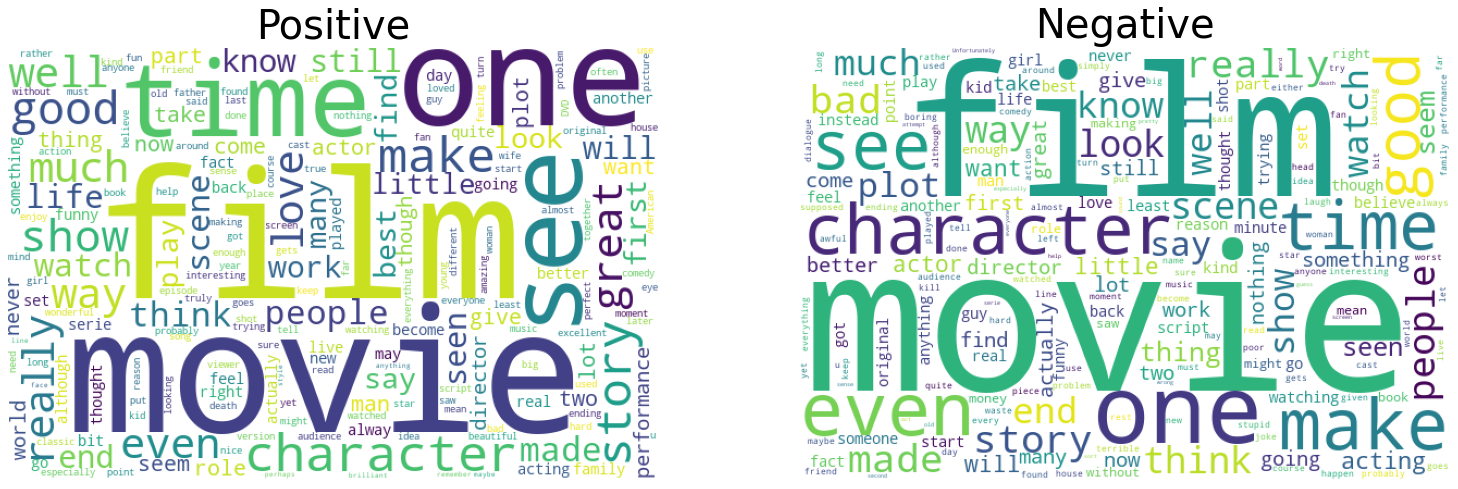

In [6]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive', fontsize=40)

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative',fontsize=40)

# NLP Preprocessing

### Neuro-Linguistic Programming

Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Some of the basic text pre-processing techniques includes:

- Make text all **lower case** or **upper case** so that the algorithm does not treat the same words in different cases as different
- **Removing Noise** i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values, common non-sensical text (/n)
- **Tokenization**: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
- **Stopword Removal**: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

### More data cleaning steps after tokenization:
- **Stemming**: Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem”.
- **Lemmatization**: A slight variant of stemming is lemmatization. The major difference between these is, that, stemming can often create non-existent words, whereas lemmas are actual words. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma. Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.
- **Parts of speech** tagging
- Create **bi-grams** or tri-grams And more...

However, it is not necessary that you would need to use all these steps. The usage depends on your problem at hand. Sometimes removal of stop words helps while at other times, this might not help.Here is a nice table taken from the blog titled: [All you need to know about Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial) that summarizes how much preprocessing you should be performing on your text data:

# <center> Toy Example

In [7]:
texts = [
    'Hello this is a sentence',
    'Hello this is another sentence',
    'Hello Hello Hello, this is mellow'
]

### Bag Of Words (BOW)

In [8]:
# create a CountVectorizer instance
bow = CountVectorizer(lowercase=True, min_df=1, max_df=3)

# fit tranform the text with it
texts_bow = bow.fit_transform(texts)

# get the features
tokens = bow.get_feature_names_out()

pd.DataFrame(data=texts_bow.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,another,hello,is,mellow,sentence,this
Text 1,0,1,1,0,1,1
Text 2,1,1,1,0,1,1
Text 3,0,3,1,1,0,1


### Bag Of Words (BOW) + ngram

In [9]:
# create a CountVectorizer instance
bow = CountVectorizer(ngram_range=(1, 2), lowercase=True, min_df=1, max_df=3)

# fit tranform the text with it
texts_bow = bow.fit_transform(texts)

# get the features
tokens = bow.get_feature_names_out()

pd.DataFrame(data=texts_bow.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,another,another sentence,hello,hello hello,hello this,is,is another,is mellow,is sentence,mellow,sentence,this,this is
Text 1,0,0,1,0,1,1,0,0,1,0,1,1,1
Text 2,1,1,1,0,1,1,1,0,0,0,1,1,1
Text 3,0,0,3,2,1,1,0,1,0,1,0,1,1


### TFIDF
A problem with the Bag of Words approach is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content”. Also, it will give more weight to longer documents than shorter documents.

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short, where:

- **Term Frequency**: is a scoring of the frequency of the word in the current document.
- **Inverse Document Frequency**: is a scoring of how rare the word is across documents.

In [10]:
#Same approach for the TfidfVectorizer

# create a TfidfVectorizer instance
tfidf = TfidfVectorizer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# # fit tranform the text with it
texts_tfidf = tfidf.fit_transform(texts)

# # get the features
tokens = tfidf.get_feature_names_out()

pd.DataFrame(data=texts_tfidf.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,another,hello,is,mellow,sentence,this
Text 1,0.000000,0.463334,0.463334,0.000000,0.596627,0.463334
Text 2,0.617227,0.364544,0.364544,0.000000,0.469417,0.364544
Text 3,0.000000,0.805627,0.268542,0.454682,0.000000,0.268542


# <center> Apply to the reviews

In [11]:
df = pd.read_csv("imdb.csv")

df_train = df.sample(frac = 0.8)
df_valid = df.drop(df_train.index)

x_train, y_train = df_train['review'], df_train['sentiment']
x_valid, y_valid = df_valid['review'], df_valid['sentiment']

### Bag Of Words 1-gram

In [12]:
%%time
bow_1gram = CountVectorizer()

train_bow_1gram = bow_1gram.fit_transform(x_train)
valid_bow_1gram = bow_1gram.transform(x_valid)

Wall time: 3.56 s


### Bag Of Words 1-2-grams

In [13]:
%%time
bow_2grams = CountVectorizer(ngram_range=(1,2))
train_bow_2grams = bow_2grams.fit_transform(x_train)
valid_bow_2grams = bow_2grams.transform(x_valid)

Wall time: 12.2 s


### TFIDF 1-gram

In [14]:
%%time
tfidf_1gram       = TfidfVectorizer()
train_tfidf_1gram = tfidf_1gram.fit_transform(x_train)
valid_tfidf_1gram = tfidf_1gram.transform(x_valid)

Wall time: 3.89 s


### TFIDF 1-2-grams

In [15]:
%%time
tfidf_2grams       = TfidfVectorizer(ngram_range=(1,2))
train_tfidf_2grams = tfidf_2grams.fit_transform(x_train)
valid_tfidf_2grams = tfidf_2grams.transform(x_valid)

Wall time: 13.6 s


In [16]:
data = [
    ("BOW 1gram",    train_bow_1gram,    valid_bow_1gram),
    ("BOW 2grams",   train_bow_2grams,   valid_bow_2grams),
    ("TFIDF 1gram",  train_tfidf_1gram,  valid_tfidf_1gram),
    ("TFIDF 2grams", train_tfidf_2grams, valid_tfidf_2grams)
]

print("BOW 1gram   ", train_bow_1gram.shape)
print("BOW 2grams  ", train_bow_2grams.shape)
print("TFIDF 1gram ", train_tfidf_1gram.shape)
print("TFIDF 2grams", train_tfidf_2grams.shape)

BOW 1gram    (20000, 68588)
BOW 2grams   (20000, 1302144)
TFIDF 1gram  (20000, 68588)
TFIDF 2grams (20000, 1302144)


# <center> ML Models

## Naive Bayes (<1 s)

In [22]:
for name, x_train, x_valid in data:
    start = time()

    # Train a MultinomialNB model and meassure the time
    mnb = MultinomialNB()
    mnb.fit(x_train, y_train)
    preds = mnb.predict(x_valid)

    a = accuracy_score(y_valid, preds)

    t = time() - start
    print(name, "\tAccuracy:\t", round(a, 3)*100, "\t\tTime:\t", round(t, 2))

BOW 1gram 	Accuracy:	 84.6 		Time:	 0.03
BOW 2grams 	Accuracy:	 88.0 		Time:	 0.19
TFIDF 1gram 	Accuracy:	 86.3 		Time:	 0.03
TFIDF 2grams 	Accuracy:	 88.8 		Time:	 0.18


## Logistic Regression (30s)

In [20]:
for name, x_train, x_valid in data:
    
    start = time()

    # Train a LogisticRegression model and meassure the time
    # scaler = StandardScaler()
    # x_train_sc = scaler.fit_transform(x_train)
    # x_valid_sc = scaler.transform(x_valid)
    
    lg = LogisticRegression(max_iter=250)
    lg.fit(x_train, y_train)
    preds = lg.predict(x_valid)

    a = accuracy_score(y_valid, preds)

    t = time() - start
    print(name, "\tAccuracy:\t" ,round(a, 3), "\t\tTime:\t" ,round(t, 2))

C:\Users\Igor\anaconda3\envs\Strive\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BOW 1gram 	Accuracy:	 0.88 		Time:	 6.8


C:\Users\Igor\anaconda3\envs\Strive\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BOW 2grams 	Accuracy:	 0.894 		Time:	 93.31
TFIDF 1gram 	Accuracy:	 0.888 		Time:	 2.13
TFIDF 2grams 	Accuracy:	 0.891 		Time:	 20.48


## Random Forest (10+90+6+22 seconds)

In [21]:
for name, x_train, x_valid in data:
        
    start = time()

    # Train a RandomForestClassifier model and meassure the time
    rfc = RandomForestClassifier()
    rfc.fit(x_train, y_train)
    preds = rfc.predict(x_valid)

    a = accuracy_score(y_valid, preds)

    t = time() - start
    print(name, "\tAccuracy:\t" ,round(a, 3), "\t\tTime:\t" ,round(t, 2))

BOW 1gram 	Accuracy:	 0.847 		Time:	 36.21
BOW 2grams 	Accuracy:	 0.858 		Time:	 204.64
TFIDF 1gram 	Accuracy:	 0.83 		Time:	 34.39
TFIDF 2grams 	Accuracy:	 0.846 		Time:	 185.19
